<a href="https://colab.research.google.com/github/GabrielPlaza95/T2-Redes-Neurais/blob/main/Trabalho%202%20Redes%20Neurais.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Importação dos dados e arquivos da tarefa

!git clone https://github.com/GabrielPlaza95/T2-Redes-Neurais.git

%cd T2-Redes-Neurais

!pip install scikeras

Cloning into 'T2-Redes-Neurais'...
remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 14 (delta 2), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (14/14), 55.30 KiB | 577.00 KiB/s, done.
/content/T2-Redes-Neurais


In [60]:
#Importação de bibliotecas e definições auxiliares

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from numpy import array
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.backend import clear_session
from sklearn import preprocessing
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, HalvingRandomSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from scikeras.wrappers import KerasRegressor
from itertools import product as cartesian_product
from math import inf

# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    sequence2=np.transpose(sequence)
    for i in range(len(sequence)):
		# find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence2[:,i:end_ix], sequence2[:,end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'b--')
    plt.plot(epochs, val_metrics, 'r-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

def print_results(y_pred, y_test):
    plt.plot(y_test)
    plt.plot(y_pred)
    plt.legend(['Original','Predicted'])
    plt.show()

    print("Resultados Teste")
    print("MAE:", mean_absolute_error(y_test, y_pred))
    print("MSE:", mean_squared_error(y_test, y_pred))
    print("MAPE:", mean_absolute_percentage_error(y_test, y_pred))
    print("R-Squared:", r2_score(y_test, y_pred))


In [70]:
# define input sequence
path = f'data/microclima.txt'
raw_data = pd.read_csv(path, )
raw_data = raw_data.value
raw_data = raw_data.array.reshape(-1, 1)

scaler = preprocessing.MinMaxScaler()
data_norm = scaler.fit_transform(raw_data)
# choose a number of time steps
n_steps = 12

# split into samples
X, y = split_sequence(data_norm, n_steps)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 12, random_state = 19)
X_train = X_train.reshape(-1, X_train.shape[-1])
X_test = X_test.reshape(-1, X_test.shape[-1])

# hyperparameters
distributions = {
    "model__activation1": ['relu', 'sigmoid', 'tanh'],
    "model__activation2": ['relu', 'sigmoid', 'tanh'],
    "model__hn1": [10, 20, 50], # number of neurons of first hidden layer
    "model__hn2": [10, 20, 50], # number of neurons of second hidden layer
    "optimizer__learning_rate": [0.001, 0.01, 0.1], # optimizer parameters
    "optimizer__momentum": [0.0, 0.001, 0.01, 0.1],
    "batch_size": [16, 32, 64],
    "epochs": list(range(10, 200, 10))
}

def create_model(activation1 = 'relu', activation2 = 'relu', hn1 = 10, hn2 = 10):
    # define model
    model = Sequential()
    model.add(Dense(hn1, activation = activation1, input_dim = n_steps, name = "escondida_1"))
    model.add(Dense(hn2, activation = activation2, name = "escondida_2"))
    model.add(Dense(1, name = "saida"))
    model.compile(loss = 'mse', metrics = ['mse'])
    return model

model = KerasRegressor(model = create_model, verbose = 0)

search = HalvingRandomSearchCV(
    estimator = model,
    scoring = 'neg_mean_squared_error',
    param_distributions = distributions,
    min_resources = 'smallest',
    factor = 4,
    cv = 2,
    n_jobs = -1,
    verbose = 0,
    random_state = 19
)

search_results = search.fit(X_train, y_train)

# summarize results
results = pd.DataFrame(search_results.cv_results_)
results = results.sort_values(by = ["rank_test_score"])[:10]
display(results[[
    "rank_test_score",
    "param_model__activation1",
    "param_model__activation2",
    "param_model__hn1",
    "param_model__hn2",
    "param_optimizer__learning_rate",
    "param_optimizer__momentum",
    "param_batch_size",
    "param_epochs",
    "mean_test_score",
    "std_test_score"
]])

search_results.best_estimator_.model_.save('best_model.h5')
clear_session()

,rank_test_score,param_model__activation1,param_model__activation2,param_model__hn1,param_model__hn2,param_optimizer__learning_rate,param_optimizer__momentum,param_batch_size,param_epochs,mean_test_score,std_test_score
39,1,tanh,tanh,50,50,0.001,0.1,64,80,-0.019154,0.000736
38,2,tanh,sigmoid,50,20,0.001,0.1,16,140,-0.020317,0.003955
36,3,tanh,tanh,50,50,0.001,0.1,64,80,-0.023491,0.007990
34,4,tanh,sigmoid,50,20,0.001,0.1,16,140,-0.037169,0.016177
30,5,tanh,relu,20,10,0.1,0.01,16,180,-0.041918,0.002362
37,6,relu,tanh,50,20,0.1,0.1,64,130,-0.045010,0.007447
31,7,tanh,sigmoid,20,50,0.01,0.1,32,20,-0.051883,0.013984
17,8,relu,tanh,50,20,0.1,0.1,64,130,-0.061651,0.020533
35,9,sigmoid,relu,10,20,0.01,0.0,64,30,-0.064104,0.021490
33,10,relu,relu,10,10,0.01,0.0,32,130,-0.067578,0.016395


Melhor Modelo:



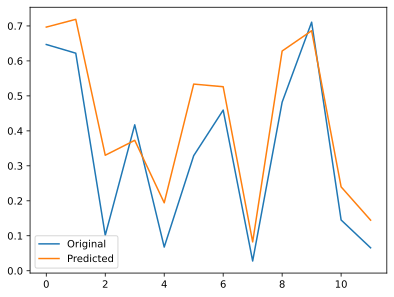

Resultados Teste
MAE: 0.10141488339116626
MSE: 0.01406726758637615
MAPE: 0.7831264134942897
R-Squared: 0.7566125608153507


In [71]:
#Melhor modelo salvo
print('Melhor Modelo:\n')

saved_model = load_model('best_model.h5')
#describe_model(saved_model, model_hyper_params)

y_pred = saved_model.predict(X_test, verbose = 0)
print_results(y_pred, y_test)

#Reset
#model_hyper_params = {}
clear_session()